In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [96]:
train_id = pd.read_csv('train_identity.csv')
train_tr = pd.read_csv('train_transaction.csv')
test_id = pd.read_csv('test_identity.csv')
test_tr = pd.read_csv('test_transaction.csv')

In [98]:
train = train_tr.merge(train_id, how='left', on = 'TransactionID')
#test = test_tr.merge(test_id, how='left', left_index=True, right_index=True)
test=test_tr.merge(test_id, how='left',on='TransactionID')

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

(590540, 434)
(506691, 433)


In [48]:
print(y_train.value_counts())


isFraud
0    569877
1     20663
Name: count, dtype: int64


In [100]:
X_test.columns = X_test.columns.str.replace('-', '_')

In [102]:
from sklearn import preprocessing

for f in X_train.columns:
    # Check if the column exists in both X_train and X_test
    if f in X_test.columns:
        if X_train[f].dtype == 'object' or X_test[f].dtype == 'object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train[f].values) + list(X_test[f].values))
            X_train[f] = lbl.transform(list(X_train[f].values))
            X_test[f] = lbl.transform(list(X_test[f].values))
    else:
        # Optionally handle columns that exist in X_train but not in X_test
        print(f"Column {f} exists in X_train but not in X_test.")
  

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, stratify = y_train,random_state = 57)

In [106]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data
X_train = scaler.fit_transform(X_train)

# Transform test data
X_valid = scaler.transform(X_valid)


In [108]:
from imblearn.over_sampling import SMOTE #Synthetic Minority Oversampling Technique, for imbalanced datasets 
from collections import Counter


smote = SMOTE(sampling_strategy='auto', random_state=57)
print("Original dataset distribution:", Counter(y_train))

# Apply SMOTE on the whole dataset
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check the new distribution after SMOTE
print("Resampled dataset distribution:", Counter(y_train))

Original dataset distribution: Counter({0: 455902, 1: 16530})
Resampled dataset distribution: Counter({0: 455902, 1: 455902})


In [110]:
# Define the model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])


In [28]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        27,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,849 (120.50 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 224 (896.00 B)

In [112]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.AUC(name='auc'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)


In [132]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=10,
        mode='max',
        restore_best_weights=True
    )
]


In [136]:
    callbacks.append(
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    )
)

In [116]:
history = model.fit(
    X_train,
    y_train,
    validation_data = (X_valid,y_valid),
    epochs=100,
    batch_size=512,
    class_weight=class_weight_dict,  # Use class weights
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.7200 - loss: 1.4574 - precision: 0.5137 - recall: 0.9690 - val_auc: 0.8516 - val_loss: 2.4961 - val_precision: 0.0351 - val_recall: 1.0000
Epoch 2/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8305 - loss: 0.9124 - precision: 0.5066 - recall: 0.9992 - val_auc: 0.8486 - val_loss: 2.5559 - val_precision: 0.0351 - val_recall: 0.9998
Epoch 3/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8488 - loss: 0.8793 - precision: 0.5090 - recall: 0.9988 - val_auc: 0.8617 - val_loss: 2.4208 - val_precision: 0.0352 - val_recall: 0.9998
Epoch 4/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8589 - loss: 0.8580 - precision: 0.5132 - recall: 0.9986 - val_auc: 0.8617 - val_loss: 2.3234 - val_precision: 0.0353 - val_recall: 0.9995
Epoch 5/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8658 - loss: 0.8434 - precision: 0.5154 - recall: 0.9984 - val_auc: 0.8575 - val_loss: 2.5636 - val_precision: 0.0355 - val_

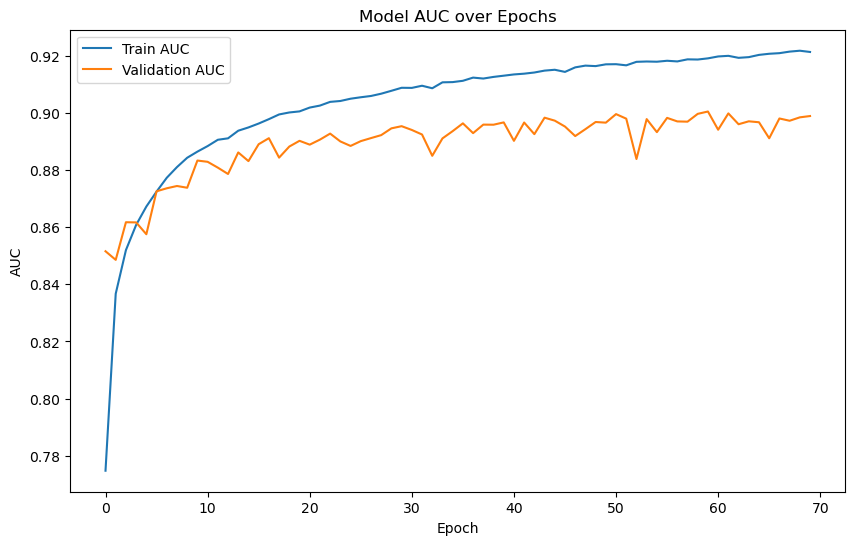

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [120]:
# Predict probabilities
y_pred_proba = model.predict(X_valid).ravel()

# Adjust threshold based on ROC curve if necessary
threshold = 0.5  # Default threshold

# Predict classes
y_pred = (y_pred_proba >= threshold).astype(int)


3691/3691 ━━━━━━━━━━━━━━━━━━━━ 1s 316us/step


In [122]:
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.30      0.46    113975
           1       0.05      0.99      0.09      4133

    accuracy                           0.33    118108
   macro avg       0.52      0.64      0.28    118108
weighted avg       0.97      0.33      0.45    118108



ROC AUC Score: 0.9012


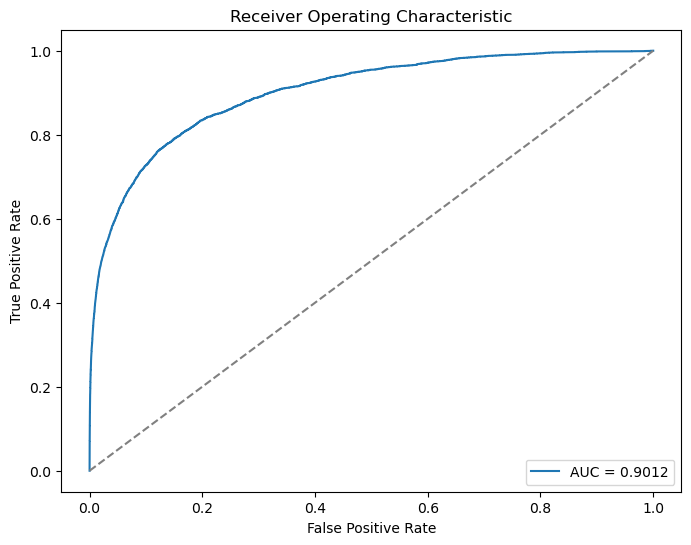

In [126]:
# Compute ROC AUC
roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
